### Imports

In [128]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### GraphQL Client

In [129]:
transport = RequestsHTTPTransport(url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3')
client = Client(transport=transport, fetch_schema_from_transport=True)

### GraphQL Query 

In [130]:
query = gql("""
    {
      pools(first: 5) {
        id
        token0 {
          id
          symbol
          name
          derivedETH
        }
        token1 {
          id
          symbol
          name
          derivedETH
        }
        totalValueLockedToken0
        totalValueLockedToken1
        totalValueLockedUSD
        volumeToken0
        volumeToken1
        volumeUSD
        feesUSD
        txCount
      }
    }
""")

### Fetch Data

In [131]:
response = client.execute(query)
print(response)

pools_data = response['pools']
df = pd.DataFrame(pools_data)
print(df)

{'pools': [{'id': '0x0000d36ab86d213c14d93cd5ae78615a20596505', 'token0': {'id': '0x60f99e81d7e9634d1de93af5301e3321c960a575', 'symbol': 'RALPH', 'name': 'Rekt Ralph', 'derivedETH': '0'}, 'token1': {'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'symbol': 'WETH', 'name': 'Wrapped Ether', 'derivedETH': '1'}, 'totalValueLockedToken0': '414784.400000000000000141', 'totalValueLockedToken1': '0.01303599250938994', 'totalValueLockedUSD': '24.67001647663118636720932031651203', 'volumeToken0': '176764324.903483719809079824', 'volumeToken1': '1.699299195469960975', 'volumeUSD': '3215.847063376039061797618238526234', 'feesUSD': '32.15847063376039061797618238526234', 'txCount': '22'}, {'id': '0x0001fcbba8eb491c3ccfeddc5a5caba1a98c4c28', 'token0': {'id': '0xbef81556ef066ec840a540595c8d12f516b6378f', 'symbol': 'BCZ', 'name': 'BinanceCZ', 'derivedETH': '0'}, 'token1': {'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'symbol': 'WETH', 'name': 'Wrapped Ether', 'derivedETH': '1'}, 'totalValueL

### Visualize Pools

C:\Users\Arjun\AppData\Local\Temp\ipykernel_13620\3376194595.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(pool_labels, rotation=45, ha='right')
C:\Users\Arjun\AppData\Local\Temp\ipykernel_13620\3376194595.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(pool_labels, rotation=45, ha='right')
C:\Users\Arjun\AppData\Local\Temp\ipykernel_13620\3376194595.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(pool_labels, rotation=45, ha='right')


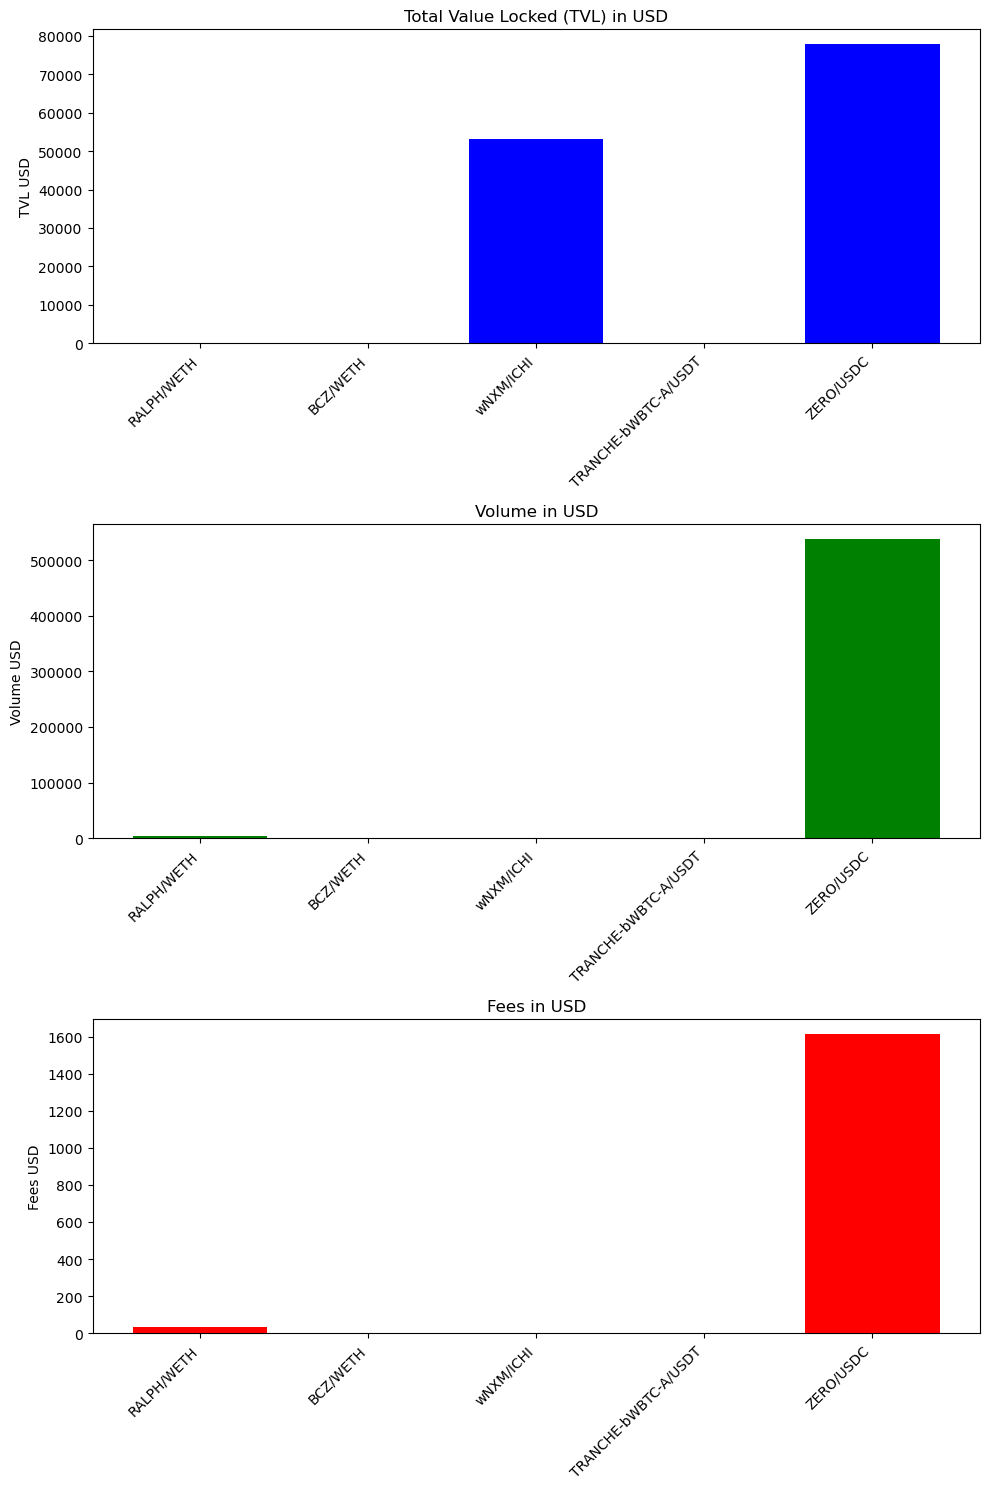

In [132]:
pool_labels = df.apply(lambda row: f"{row['token0']['symbol']}/{row['token1']['symbol']}", axis=1)
tvl_usd = df['totalValueLockedUSD'].astype(float)
volume_usd = df['volumeUSD'].astype(float)
fees_usd = df['feesUSD'].astype(float)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].bar(pool_labels, tvl_usd, color='blue')
axes[0].set_title('Total Value Locked (TVL) in USD')
axes[0].set_ylabel('TVL USD')
axes[0].set_xticklabels(pool_labels, rotation=45, ha='right')

axes[1].bar(pool_labels, volume_usd, color='green')
axes[1].set_title('Volume in USD')
axes[1].set_ylabel('Volume USD')
axes[1].set_xticklabels(pool_labels, rotation=45, ha='right')

axes[2].bar(pool_labels, fees_usd, color='red')
axes[2].set_title('Fees in USD')
axes[2].set_ylabel('Fees USD')
axes[2].set_xticklabels(pool_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Impermanent Loss Function

In [133]:
def calculate_impermanent_loss(price_change):
    return 2 * np.sqrt(price_change) / (1 + price_change)

### Static Provision Simulation Function

In [134]:
def simulate_static_provision(df, days_held, daily_volume, fee_percent):
    df['fees_earned'] = daily_volume * fee_percent * days_held
    df['impermanent_loss'] = calculate_impermanent_loss(df['price_change'])
    df['net_return'] = df['fees_earned'] - df['impermanent_loss']
    return df

### Simulation

c:\Users\Arjun\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


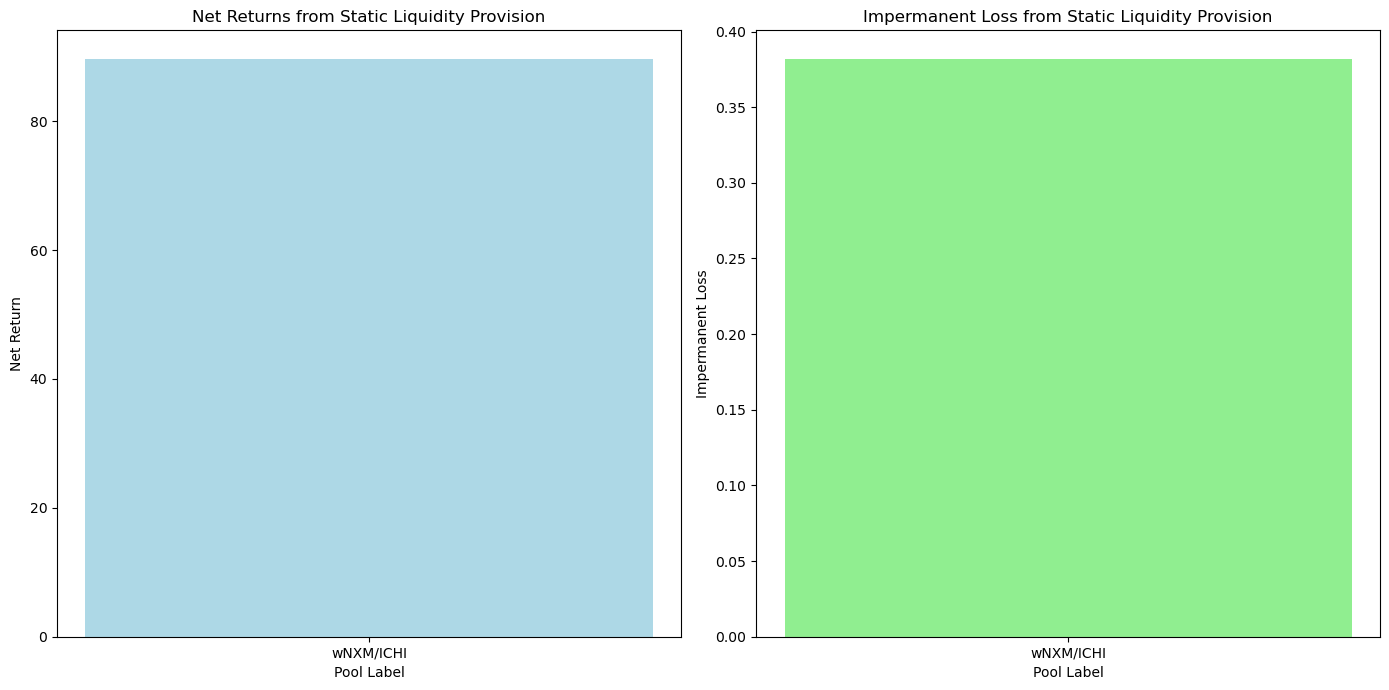

In [135]:
df['price_change'] = df.apply(
    lambda row: (float(row['token0']['derivedETH']) - float(row['token1']['derivedETH'])) 
                / float(row['token1']['derivedETH']) if row['token1']['derivedETH'] != '0' else 0,
    axis=1
)

days_held = 30
daily_volume = 1000  # Constant daily volume
fee_percent = 0.003 # 0.3% fee

df_simulated = simulate_static_provision(df, days_held, daily_volume, fee_percent)


plt.figure(figsize=(14, 7))

plt.subplot(121)
plt.bar(pool_labels, df_simulated['net_return'], color='lightblue')
plt.title('Net Returns from Static Liquidity Provision')
plt.xlabel('Pool Label')
plt.ylabel('Net Return')

plt.subplot(122)
plt.bar(pool_labels, df_simulated['impermanent_loss'], color='lightgreen')
plt.title('Impermanent Loss from Static Liquidity Provision')
plt.xlabel('Pool Label')
plt.ylabel('Impermanent Loss')

plt.tight_layout()
plt.show()